In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

import os
import numpy as np
import torch

rng = np.random.default_rng()

# Mixture of 2D Gaussian

## Prepare data samples

In [2]:
num_samples = 5000

ps = [0.5, 0.3, 0.2]
means = [
    (1, 0), (0, 1), (-1, -1),
]
stds = [
    (1, 0.8), (1, 0.6), (1, 0.4),
]
thetas = [
    0, np.pi/2, np.pi/3,
]

xs = []
for i in range(3):
    _xs = rng.normal(size=(int(ps[i]*num_samples), 2))
    _xs *= np.array(stds[i])
    mat = np.array([
        [np.cos(thetas[i]), -np.sin(thetas[i])],
        [np.sin(thetas[i]), np.cos(thetas[i])],
    ])
    _xs = np.matmul(_xs, mat)
    _xs += np.array(means[i])
    xs.append(_xs)
xs = np.concatenate(xs)

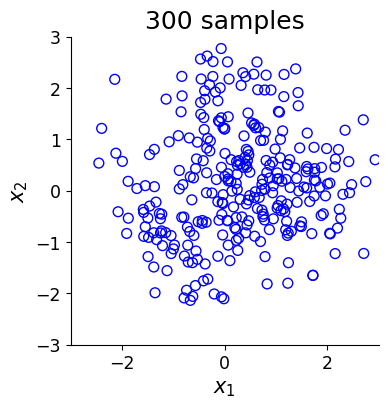

In [3]:
_, ax = plt.subplots(figsize=(4, 4))
idxs = rng.choice(num_samples, 300, replace=False)
ax.scatter(xs[idxs, 0], xs[idxs, 1], s=50, marker='o', facecolor='none', edgecolor='blue')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal')
ax.set_title('{} samples'.format(len(idxs)))
plt.show()

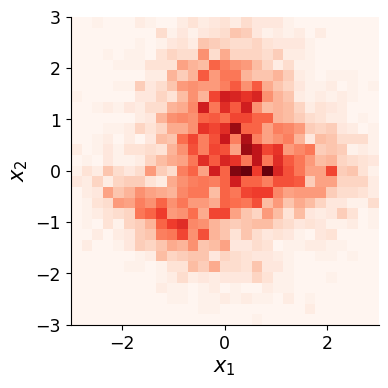

In [4]:
heatmap, *_ = np.histogram2d(xs[:, 0], xs[:, 1], np.linspace(-3, 3, 30))
_, ax = plt.subplots(figsize=(4, 4))
ax.imshow(heatmap, extent=[-3, 3, -3, 3], origin='lower', cmap='Reds')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

## Discretize into integers

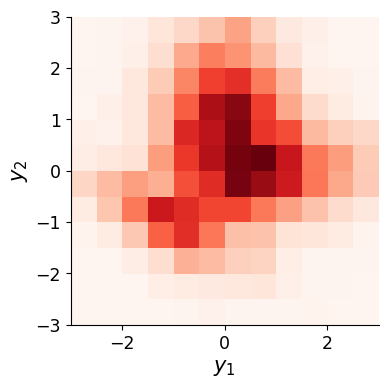

In [5]:
resol = 0.5
num_levels = int(6/resol)
ys = np.floor((xs+3)/resol).astype(int)
ys[ys<0] = 0
ys[ys>=num_levels] = num_levels-1

heatmap, *_ = np.histogram2d(ys[:, 0], ys[:, 1], np.arange(num_levels+1)-0.5)
_, ax = plt.subplots(figsize=(4, 4))
ax.imshow(heatmap, extent=[-3, 3, -3, 3], origin='lower', cmap='Reds')
ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
plt.show()

# Create discrete distribution

In [6]:
from irc.space import DiscreteVarSpace

spaces = [DiscreteVarSpace(num_levels), DiscreteVarSpace(num_levels)]
y1, y2 = np.meshgrid(np.arange(num_levels), np.arange(num_levels))

## Assume $y_1$ and $y_2$ are independent

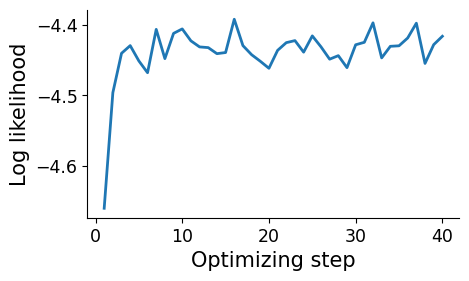

In [7]:
from irc.distribution import create_distribution

dist = create_distribution(spaces)
param_vec, stats = dist.estimate(torch.tensor(ys))

_, ax = plt.subplots()
ax.plot(stats['steps'], -stats['losses'])
ax.set_xlabel('Optimizing step')
ax.set_ylabel('Log likelihood')
plt.show()

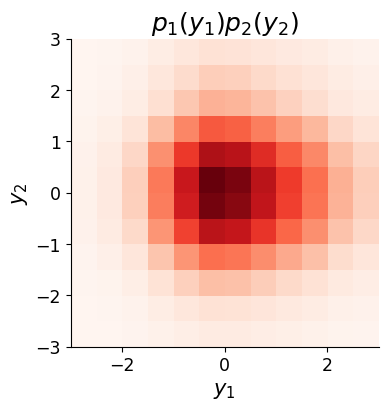

In [8]:
ps = dist.loglikelihoods(torch.tensor(np.stack([y1.reshape(-1), y2.reshape(-1)], axis=1)), param_vec).exp()
ps = ps.numpy().reshape(y1.shape)

_, ax = plt.subplots(figsize=(4, 4))
ax.imshow(ps, extent=[-3, 3, -3, 3], origin='lower', cmap='Reds')
ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
ax.set_title('$p_1(y_1)p_2(y_2)$')
plt.show()

# Assume $y_1$ and $y_2$ dependent

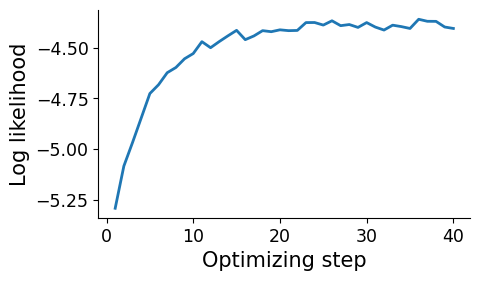

In [9]:
dist = create_distribution(spaces, {'idcs': [[0, 1]]})
param_vec, stats = dist.estimate(torch.tensor(ys))

_, ax = plt.subplots()
ax.plot(stats['steps'], -stats['losses'])
ax.set_xlabel('Optimizing step')
ax.set_ylabel('Log likelihood')
plt.show()

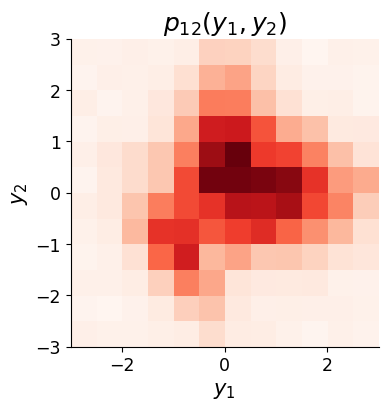

In [10]:
ps = dist.loglikelihoods(torch.tensor(np.stack([y1.reshape(-1), y2.reshape(-1)], axis=1)), param_vec).exp()
ps = ps.numpy().reshape(y1.shape)

_, ax = plt.subplots(figsize=(4, 4))
ax.imshow(ps, extent=[-3, 3, -3, 3], origin='lower', cmap='Reds')
ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
ax.set_title('$p_{12}(y_1, y_2)$')
plt.show()

# Create continuous distribution

In [11]:
from irc.space import ContinuousVarSpace

spaces = [ContinuousVarSpace(), ContinuousVarSpace()]
for i in range(2):
    spaces[i].update_anchors(torch.tensor(xs[:, i]), resol=50)
x1, x2 = np.meshgrid(np.linspace(-3, 3, 90), np.linspace(-3, 3, 90))

## Assume $x_1$ and $x_2$ are independent

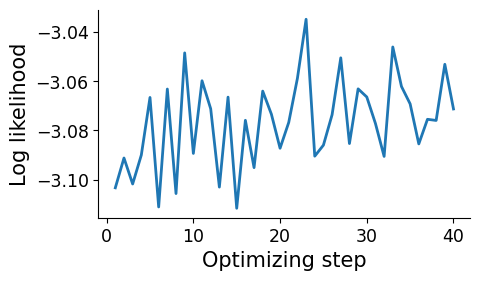

In [12]:
dist = create_distribution(spaces)
param_vec, stats = dist.estimate(torch.tensor(xs))

_, ax = plt.subplots()
ax.plot(stats['steps'], -stats['losses'])
ax.set_xlabel('Optimizing step')
ax.set_ylabel('Log likelihood')
plt.show()

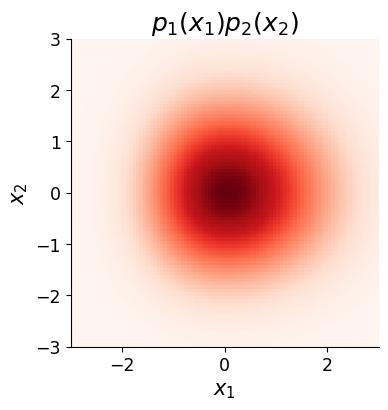

In [13]:
ps = dist.loglikelihoods(torch.tensor(np.stack([x1.reshape(-1), x2.reshape(-1)], axis=1)), param_vec).exp()
ps = ps.numpy().reshape(x1.shape)

_, ax = plt.subplots(figsize=(4, 4))
ax.imshow(ps, extent=[-3, 3, -3, 3], origin='lower', cmap='Reds')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$p_1(x_1)p_2(x_2)$')
plt.show()

## Assume $x_1$ and $x_2$ dependent

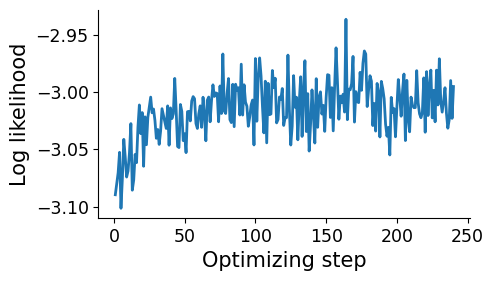

In [14]:
dist = create_distribution(spaces, {'phis': [{'mlp_features': [32, 4]}],'idcs': [[0, 1]]})
param_vec, stats = dist.estimate(torch.tensor(xs), num_epochs=240)

_, ax = plt.subplots()
ax.plot(stats['steps'], -stats['losses'])
ax.set_xlabel('Optimizing step')
ax.set_ylabel('Log likelihood')
plt.show()

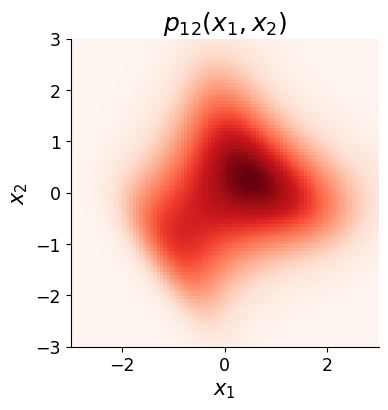

In [15]:
ps = dist.loglikelihoods(torch.tensor(np.stack([x1.reshape(-1), x2.reshape(-1)], axis=1)), param_vec).exp()
ps = ps.numpy().reshape(x1.shape)

_, ax = plt.subplots(figsize=(4, 4))
ax.imshow(ps, extent=[-3, 3, -3, 3], origin='lower', cmap='Reds')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$p_{12}(x_1,x_2)$')
plt.show()

# Stochastic estimation

Effective sample number: 50


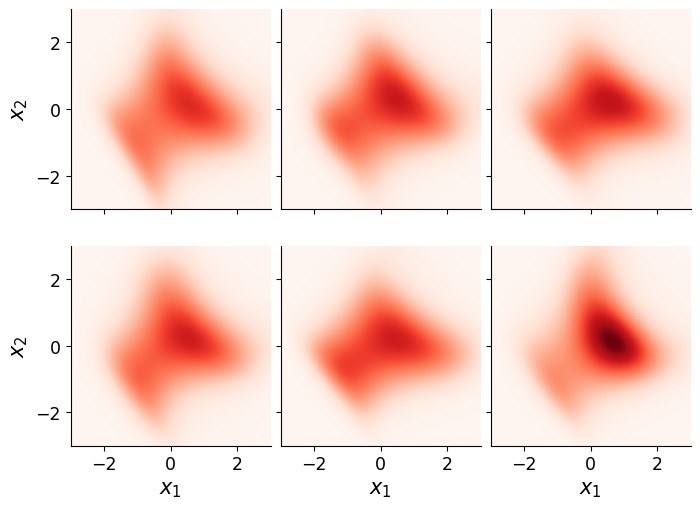

Effective sample number: 500


In [ ]:
for ll_scale in [50, 500, 5000]:
    print(f'Effective sample number: {ll_scale}')
    
    ps_list = []
    for _ in range(6):
        _param_vec, _ = dist.estimate(torch.tensor(xs), param_vec=param_vec, num_epochs=0, ll_scale=ll_scale)
        ps = dist.loglikelihoods(torch.tensor(np.stack([x1.reshape(-1), x2.reshape(-1)], axis=1)), _param_vec).exp()
        ps = ps.numpy().reshape(x1.shape)
        ps_list.append(ps)

    vlim = np.array(ps_list).max()
    _, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True, sharey=True, gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(ps_list[i], extent=[-3, 3, -3, 3], vmin=0, vmax=vlim, origin='lower', cmap='Reds')
        if ax in axes[-1]:
            ax.set_xlabel('$x_1$')
        if ax in axes[:, 0]:
            ax.set_ylabel('$x_2$')
    plt.show()